## AlexNet

### 前處理

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

train_dir = "C:/Users/ycliou/Desktop/xray/8020/train"
categories = ["n", "p"]
test_dir = "C:/Users/ycliou/Desktop/xray/8020/test"
categories1 = ["n", "p"]

# 檢查是否成功加載並顯示第一張圖像
for category in categories:
    path = os.path.join(train_dir, category)
    for img in os.listdir(path):
        if img.endswith((".jpg", ".png", ".jpeg")):  # 只處理圖像文件
            img_array = cv2.imread(os.path.join(path, img))
            if img_array is not None:
                plt.imshow(img_array)
                plt.show()
            else:
                print(f"圖像 {img} 加載失敗")
        break
    break

In [3]:
IMG_SIZE = 224
# 創建訓練集列表
training_data = []

def create_training_data():
    for category in categories:
        path = os.path.join(train_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                if img.endswith((".jpg", ".png", ".jpeg")):  # 只處理圖像文件
                    img_array = cv2.imread(os.path.join(path, img))
                    if img_array is not None:  # 檢查圖像是否成功加載
                        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                        training_data.append([new_array, class_num])
                    else:
                        print(f"圖像 {img} 加載失敗")
            except Exception as e:
                print(f"處理圖像 {img} 時出錯: {str(e)}")

create_training_data()

# 創建測試集列表
testing_data = []

def create_testing_data():
    for category1 in categories1:
        path1 = os.path.join(test_dir, category1)
        class_num1 = categories1.index(category1)
        for img1 in os.listdir(path1):
            try:
                if img1.endswith((".jpg", ".png", ".jpeg")):  # 只处理图像文件
                    img_array1 = cv2.imread(os.path.join(path1, img1))
                    if img_array1 is not None:  # 检查图像是否成功加载
                        new_array1 = cv2.resize(img_array1, (IMG_SIZE, IMG_SIZE))
                        testing_data.append([new_array1, class_num1])
                    else:
                        print(f"圖像 {img1} 加載失敗")
            except Exception as e:
                print(f"處理圖像 {img1} 時出錯: {str(e)}")

create_testing_data()

In [4]:
# 隨機打亂訓練及測試集
random.shuffle(training_data)
random.shuffle(testing_data)

In [5]:
# 分別創建訓練集和測試集的特徵和標籤
X_train = []
y_train = []

X_test = []
y_test = []

for features_train, label_train in training_data:
    X_train.append(features_train)
    y_train.append(label_train)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE, 3)

for features_test, label_test in testing_data:
    X_test.append(features_test)
    y_test.append(label_test)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape(X_test.shape[0], IMG_SIZE, IMG_SIZE, 3)

# 將像素進行歸一化
X_train = X_train / 255.0
X_test = X_test / 255.0

print("訓練集樣本數:", len(X_train))
print("測試集樣本數:", len(X_test))

訓練集樣本數: 5100
測試集樣本數: 1172


### 模型建立

#### 優化器：Adam

In [29]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

IMG_SIZE = 224

# 建立二分類模型
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', padding="same", input_shape=(IMG_SIZE, IMG_SIZE,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')   
])

# 編譯模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 設定早停
early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.0001, restore_best_weights=True)

# 訓練模型
history = model.fit(X_train, y_train, batch_size=32, epochs=600, validation_data=(X_test,y_test), callbacks=[early_stopping], shuffle=True, verbose=2)

Epoch 1/600
160/160 - 4s - loss: 2.5092 - accuracy: 0.7994 - val_loss: 2.4160 - val_accuracy: 0.7474 - 4s/epoch - 26ms/step
Epoch 2/600
160/160 - 3s - loss: 0.2980 - accuracy: 0.8975 - val_loss: 0.4484 - val_accuracy: 0.8097 - 3s/epoch - 16ms/step
Epoch 3/600
160/160 - 3s - loss: 0.2197 - accuracy: 0.9229 - val_loss: 1.6808 - val_accuracy: 0.7619 - 3s/epoch - 17ms/step
Epoch 4/600
160/160 - 3s - loss: 0.2134 - accuracy: 0.9314 - val_loss: 0.1193 - val_accuracy: 0.9599 - 3s/epoch - 17ms/step
Epoch 5/600
160/160 - 3s - loss: 0.2004 - accuracy: 0.9290 - val_loss: 0.7382 - val_accuracy: 0.7833 - 3s/epoch - 17ms/step
Epoch 6/600
160/160 - 3s - loss: 0.1841 - accuracy: 0.9386 - val_loss: 1.6383 - val_accuracy: 0.5640 - 3s/epoch - 17ms/step
Epoch 7/600
160/160 - 3s - loss: 0.2210 - accuracy: 0.9361 - val_loss: 0.3171 - val_accuracy: 0.8677 - 3s/epoch - 16ms/step
Epoch 8/600
160/160 - 3s - loss: 0.1665 - accuracy: 0.9408 - val_loss: 0.4281 - val_accuracy: 0.8541 - 3s/epoch - 16ms/step
Epoch 9/

#### 優化器：SGD

In [19]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

IMG_SIZE = 224

# 建立二分類模型
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', padding="same", input_shape=(IMG_SIZE, IMG_SIZE,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')   
])

# 編譯模型
optimizer = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 設定早停
early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.0001, restore_best_weights=True)

# 訓練模型
history = model.fit(X_train, y_train, batch_size=32, epochs=600, validation_data=(X_test,y_test), callbacks=[early_stopping], shuffle=True, verbose=2)

Epoch 1/600
160/160 - 3s - loss: 0.4915 - accuracy: 0.8251 - val_loss: 0.5736 - val_accuracy: 0.7372 - 3s/epoch - 18ms/step
Epoch 2/600
160/160 - 2s - loss: 0.2583 - accuracy: 0.9049 - val_loss: 1.1533 - val_accuracy: 0.7372 - 2s/epoch - 12ms/step
Epoch 3/600
160/160 - 2s - loss: 0.2169 - accuracy: 0.9245 - val_loss: 0.2104 - val_accuracy: 0.9078 - 2s/epoch - 13ms/step
Epoch 4/600
160/160 - 2s - loss: 0.1767 - accuracy: 0.9357 - val_loss: 0.1343 - val_accuracy: 0.9522 - 2s/epoch - 13ms/step
Epoch 5/600
160/160 - 2s - loss: 0.1631 - accuracy: 0.9402 - val_loss: 0.1126 - val_accuracy: 0.9556 - 2s/epoch - 13ms/step
Epoch 6/600
160/160 - 2s - loss: 0.1488 - accuracy: 0.9451 - val_loss: 0.2863 - val_accuracy: 0.8848 - 2s/epoch - 12ms/step
Epoch 7/600
160/160 - 2s - loss: 0.1502 - accuracy: 0.9449 - val_loss: 0.1490 - val_accuracy: 0.9488 - 2s/epoch - 12ms/step
Epoch 8/600
160/160 - 2s - loss: 0.1487 - accuracy: 0.9463 - val_loss: 0.2004 - val_accuracy: 0.9283 - 2s/epoch - 12ms/step
Epoch 9/

### 指標

#### 優化器：Adam

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# 評估測試集（當前用作驗證）
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"ADAM測試集 (用作驗證) 結果 - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

ADAM測試集 (用作驗證) 結果 - Loss: 0.0981, Accuracy: 0.9642


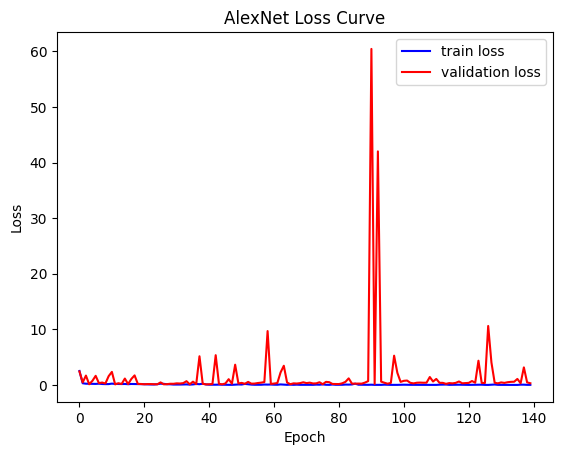

In [31]:
# Adam
plt.plot(history.history['loss'],'b',label = "train loss")
plt.plot(history.history['val_loss'],'r',label = "validation loss")
plt.title('AlexNet Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

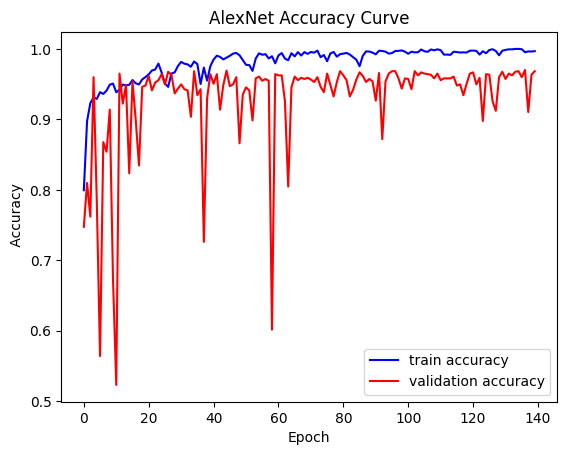

In [32]:
# Adam
plt.plot(history.history['accuracy'],'b',label = "train accuracy")
plt.plot(history.history['val_accuracy'],'r',label = "validation accuracy")
plt.title('AlexNet Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel(' Accuracy')
plt.legend()
plt.show()

37/37 [==============================] - 0s 5ms/step


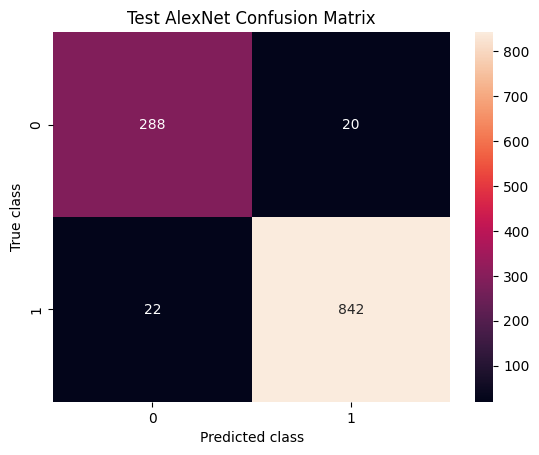

TP: 842, FP: 20, FN: 22, TN: 288
accuracy： 0.9641638225255973
precision： 0.9767981438515081
recall： 0.9745370370370371
f1 score： 0.9756662804171495
KAPPA： 0.9077054614726927
sensitivity： 0.9745370370370371
specificity： 0.935064935064935


In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
# 進行預測
#predict = model.predict(X_test).argmax(axis=1)

# 進行預測，使用閾值 0.5 進行二分類
predict = (model.predict(X_test) > 0.5).astype("int32")

# 計算混淆矩陣
matrix = confusion_matrix(y_test, predict)

# 畫出混淆矩陣熱力圖
sns.heatmap(matrix, annot=True, fmt='d')
plt.title('Test AlexNet Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

# 提取 TP, FP, FN, TN
tp = matrix[1,1]  # True Positive
fp = matrix[0,1]  # False Positive
fn = matrix[1,0]  # False Negative
tn = matrix[0,0]  # True Negative

print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

# 模型指標
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

po = (tp + tn) / (tp + fp + fn + tn)
pe = ((tp + fp) * (tp + fn) + (tn + fp) * (tn + fn)) / (tp + fp + fn + tn) ** 2
kappa = (po - pe) / (1 - pe)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("accuracy：",accuracy)
print("precision：",precision)
print("recall：",recall)
print("f1 score：",f1)
print("KAPPA：",kappa)
print("sensitivity：",sensitivity)
print("specificity：",specificity)

#### 優化器：SGD

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# 評估測試集（當前用作驗證）
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"SGD測試集 (用作驗證) 結果 - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

ADAM測試集 (用作驗證) 結果 - Loss: 0.0965, Accuracy: 0.9693


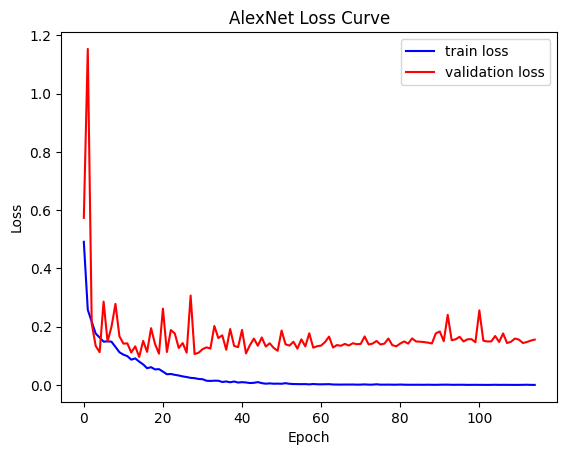

In [21]:
# SDG
plt.plot(history.history['loss'],'b',label = "train loss")
plt.plot(history.history['val_loss'],'r',label = "validation loss")
plt.title('AlexNet Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

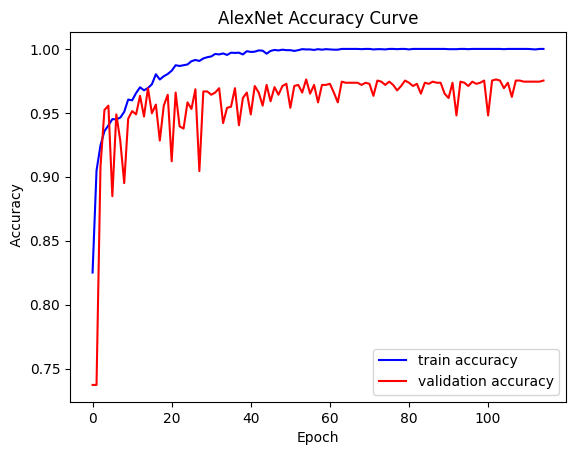

In [22]:
# SDG
plt.plot(history.history['accuracy'],'b',label = "train accuracy")
plt.plot(history.history['val_accuracy'],'r',label = "validation accuracy")
plt.title('AlexNet Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel(' Accuracy')
plt.legend()
plt.show()

37/37 [==============================] - 0s 6ms/step


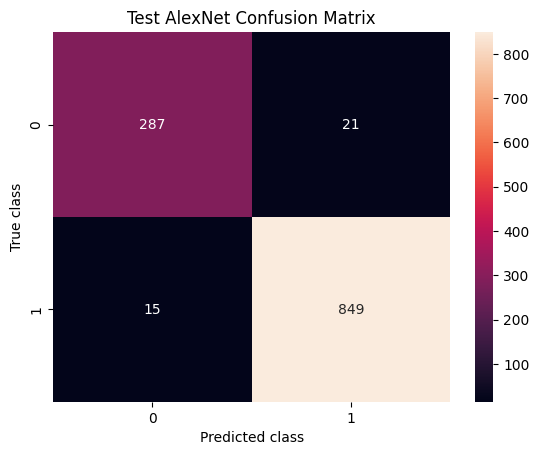

TP: 849, FP: 21, FN: 15, TN: 287
accuracy： 0.9692832764505119
precision： 0.9758620689655172
recall： 0.9826388888888888
f1 score： 0.9792387543252595
KAPPA： 0.9202250760085311
sensitivity： 0.9826388888888888
specificity： 0.9318181818181818


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# 進行預測
#predict = model.predict(X_test).argmax(axis=1)

# 進行預測，使用閾值 0.5 進行二分類
predict = (model.predict(X_test) > 0.5).astype("int32")

# 計算混淆矩陣
matrix = confusion_matrix(y_test, predict)

# 畫出混淆矩陣熱力圖
sns.heatmap(matrix, annot=True, fmt='d')
plt.title('Test AlexNet Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

# 提取 TP, FP, FN, TN
tp = matrix[1,1]  # True Positive
fp = matrix[0,1]  # False Positive
fn = matrix[1,0]  # False Negative
tn = matrix[0,0]  # True Negative

print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

# 模型指標
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

po = (tp + tn) / (tp + fp + fn + tn)
pe = ((tp + fp) * (tp + fn) + (tn + fp) * (tn + fn)) / (tp + fp + fn + tn) ** 2
kappa = (po - pe) / (1 - pe)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("accuracy：",accuracy)
print("precision：",precision)
print("recall：",recall)
print("f1 score：",f1)
print("KAPPA：",kappa)
print("sensitivity：",sensitivity)
print("specificity：",specificity)